In [2]:
import glob
import scanpy as sc
import h5py
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Read seurat annotations

In [3]:
files = sorted(glob('../data/uzorci/*.h5ad'))
# Load AnnData objects
adata_list = [sc.read_h5ad(file) for file in files]
sample_names = ['Sample 1 - 40 nm NPs', 'Sample 2 - 200 nm NPs', 'Sample 3 - 40 + 200 nm NPs', 'Sample 4 - control']


In [87]:
set(adata_list[0].obs['predicted.celltype']).intersection(set(adata_list[1].obs['predicted.celltype'])).intersection(set(adata_list[2].obs['predicted.celltype']))

{'B cell', 'CD14+ monocyte', 'CD4+ T cell', 'Cytotoxic T cell'}

/Users/vladimirk/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/vladimirk/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/vladimirk/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map)

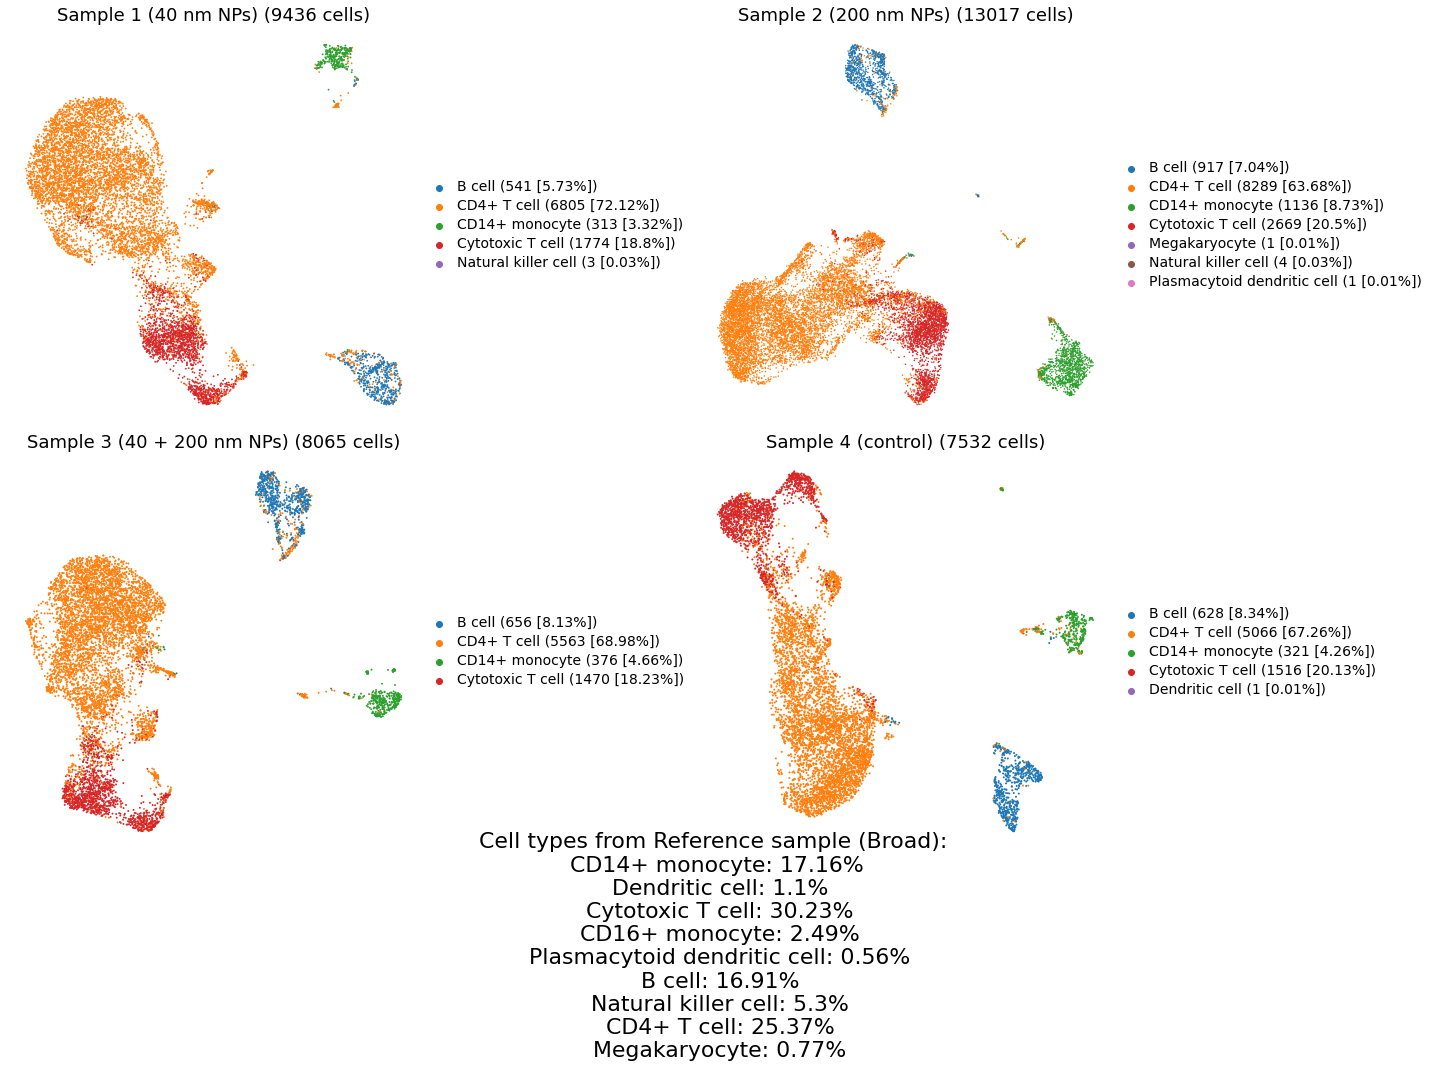

In [85]:
# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()
cell_type_col = "predicted.celltype"  # Annotation column name

for i, (adata, ax) in enumerate(zip(adata_list, axes)):
    # Calculate cell type counts and percentages

    cell_counts = adata.obs[cell_type_col].value_counts()
    total_cells = cell_counts.sum()
    percentages = (cell_counts / total_cells * 100).round(2)
    
    # Modify categories to include counts and percentages
    updated_categories = [
        f"{cell_type} ({count} [{percentage}%])"
        for cell_type, count, percentage in zip(cell_counts.index, cell_counts, percentages)
    ]
    mapping = dict(zip(cell_counts.index, updated_categories)) 
    adata.obs[cell_type_col + "_updated"] = adata.obs[cell_type_col].map(mapping)#.fillna("Unknown")
    
    # Plot UMAP
    sc.pl.umap(
        adata,
        color=cell_type_col + "_updated",
        ax=ax,
        show=False,
        title=sample_names[i],
        legend_loc="right margin"
    )
    ax.set_title(f'{sample_names[i]} ({len(adata)} cells)', size=18)
    # Remove frame around each subplot
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    # Increase the legend font size
    legend = ax.get_legend()
    if legend:
        for text in legend.get_texts():
            text.set_fontsize(14)  # Adjust the font size
    ax.set_xlabel(None)
    ax.set_ylabel(None)


# Add a horizontal legend at the bottom of the figure with reference cell types
# Define legend items and title
data = Counter(adata_ref.obs['CellType'])
total = sum(data.values())
# percentages = {key: np.round(value / total, 2) * 100 for key, value in data.items()}
legend_items = [f'{key}: {np.round(value / total * 100, 2)}' for key, value in data.items() if not str(key) in ['Unassigned', 'nan']]

fig.text(
    0.5, -0.1,  # Position: centered horizontally, slightly below the figure
    "Cell types from Reference sample (Broad): \n" + "%\n ".join(legend_items) + '%',  # Legend text
    ha='center', va='center', fontsize=22  # Alignment and font size
)

# Adjust layout and display
plt.tight_layout()
plt.savefig('nano.png', dpi=150, bbox_inches='tight')
plt.show()


In [4]:
# Add prefix to the index in `.obs` for each AnnData object to make them unique
for i, adata in enumerate(adata_list):
    adata.obs['sample'] = f'sample_{i+1}'  # Add a column 'sample' to keep track of the sample source
    adata.obs.index = [f"{f'sample_{i+1}'}_{x}" for x in adata.obs.index]  # Modify the index to be unique

# Step 2: Merge all AnnData objects
merged_adata = adata_list[0].concatenate(adata_list[1:], join='inner', index_unique=None)
merged_adata.write_h5ad('merged.h5ad', compression='gzip')

/Users/vladimirk/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


# Obsolete - with filtered files

In [2]:

path ='../data/'
# Paths for the filtered feature and molecule info files
filtered_feature_paths = [
    "filtered_feature_bc_matrix.h5",
    "filtered_feature_bc_matrix_Sample2.h5",
    "filtered_feature_bc_matrix_Sample3.h5",
    "filtered_feature_bc_matrix_Sample4.h5"
]

molecule_info_paths = [
    "molecule_info.h5",
    "molecule_info_Sample2.h5",
    "molecule_info_Sample3.h5",
    "molecule_info_Sample4.h5"
]

# Load each filtered feature file as an AnnData object and add sample ID
anndata_objects = []
mi_objects = []
for i, (ff_path, mi_path) in enumerate(zip(filtered_feature_paths, molecule_info_paths), start=1):
    # Load the filtered feature matrix
    adata = sc.read_10x_h5(path + ff_path)
    
    adata.obs['sample'] = f"{i}"
#     adata.var_names_make_unique()
    adata.obs.index = [f'{i}_{x}' for x in adata.obs.index]
    
    # Load additional information from molecule_info.h5
    with h5py.File(path + mi_path, 'r') as f:
        # Here we load data from molecule_info as an example
        # Adjust this part depending on what specific information you need
        mi_objects.append(f)

    # Add the AnnData object to the list
    anndata_objects.append(adata)
    display(anndata_objects[i-1].var.index)

# Display each AnnData object
for i, adata in enumerate(anndata_objects, start=1):
    print(f"Sample {i}: {adata}")


/Users/vladimirk/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/vladimirk/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10',
       ...
       'KIR3DL2', 'AL590523.1', 'CT476828.1', 'PNRC2', 'SRSF10', 'AC145205.1',
       'BAGE5', 'CU459201.1', 'AC002321.2', 'AC002321.1'],
      dtype='object', length=32738)

/Users/vladimirk/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/vladimirk/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10',
       ...
       'KIR3DL2', 'AL590523.1', 'CT476828.1', 'PNRC2', 'SRSF10', 'AC145205.1',
       'BAGE5', 'CU459201.1', 'AC002321.2', 'AC002321.1'],
      dtype='object', length=32738)

/Users/vladimirk/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/vladimirk/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10',
       ...
       'KIR3DL2', 'AL590523.1', 'CT476828.1', 'PNRC2', 'SRSF10', 'AC145205.1',
       'BAGE5', 'CU459201.1', 'AC002321.2', 'AC002321.1'],
      dtype='object', length=32738)

/Users/vladimirk/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/vladimirk/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10',
       ...
       'KIR3DL2', 'AL590523.1', 'CT476828.1', 'PNRC2', 'SRSF10', 'AC145205.1',
       'BAGE5', 'CU459201.1', 'AC002321.2', 'AC002321.1'],
      dtype='object', length=32738)

Sample 1: AnnData object with n_obs × n_vars = 8743 × 32738
    obs: 'sample'
    var: 'gene_ids', 'feature_types', 'genome'
Sample 2: AnnData object with n_obs × n_vars = 12703 × 32738
    obs: 'sample'
    var: 'gene_ids', 'feature_types', 'genome'
Sample 3: AnnData object with n_obs × n_vars = 6176 × 32738
    obs: 'sample'
    var: 'gene_ids', 'feature_types', 'genome'
Sample 4: AnnData object with n_obs × n_vars = 6546 × 32738
    obs: 'sample'
    var: 'gene_ids', 'feature_types', 'genome'


In [ ]:
import scanpy as sc

# Set scanpy settings for reproducibility and high-quality images
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Process each AnnData object in anndata_objects list separately
for i, adata in enumerate(anndata_objects, start=1):
    # Basic QC metrics
#     sc.pp.calculate_qc_metrics(adata, inplace=True)
    
    # Filter cells and genes
    sc.pp.filter_cells(adata, min_counts=50)
    sc.pp.filter_genes(adata, min_cells=5)
    
    # Normalize and log transform
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    # Identify highly variable genes
    sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=2000)
    
    # Scale the data and apply PCA
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    
    # Build the neighborhood graph
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    
    # Run UMAP for dimensionality reduction
    sc.tl.umap(adata)
    
    # Perform Leiden clustering
    sc.tl.leiden(adata, resolution=1.0)
    
    # Find marker genes for each cluster
    sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
    
    # Visualize UMAP and clusters for each sample
    print(f"Visualizations for Sample {i}")
    sc.pl.umap(adata, color=['leiden'], legend_loc='on data', title=f"Sample {i} - UMAP with Leiden Clusters")
    sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, title=f"Sample {i} - Marker Genes")

    # Optional: Save each processed AnnData object if needed
    # adata.write(f"processed_sample_{i}.h5ad")



-----
anndata     0.9.2
scanpy      1.9.5
-----
PIL                         9.0.1
appnope                     0.1.2
asciitree                   NA
asttokens                   NA
backcall                    0.2.0
bottleneck                  1.3.6
cffi                        1.15.0
cloudpickle                 2.0.0
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.11.0
dask                        2022.02.1
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   4.4.2
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fasteners                   0.17.3
fsspec                      2022.02.0
gmpy2                       2.1.2
google                      NA
h5py                        3.6.0
igraph                      0.9.11
importlib_resources         NA
ipykernel                   6.9.1
ipython_genutils            0.2.0
jedi

/Users/vladimirk/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/vladimirk/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/Users/vladimirk/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:247: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 40


/Users/vladimirk/opt/anaconda3/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
